# Predicción de demanda de taxis en aeropuertos

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

- La métrica RECM en el conjunto de prueba no debe ser superior a 48.


## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Inicialización

In [280]:
# Carga todas las librerías

# Manipulación de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelado
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Visualización
import matplotlib.pyplot as plt

## Cargar los datos

In [281]:
# Carga los datos en DataFrames tomando en cuenta que la primera columna es de tipo fecha
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except Exception:
    df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

## Preparación

In [282]:
# Imprime la información general/resumen sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Conclusión intermedia

- Se utilizó la primer columna de tipo `Datetime` como índice.
- No existen valores nulos en la única columa `num_orders`, además de que es del tipo de dato correcto.

In [283]:
# Ordena el DataFrame por fecha usando el índice
df = df.sort_index()

In [284]:
# Realizar remuestreo de los datos a 1 hora
df = df.resample('1H').sum()

In [285]:
# Imprime las primeras 5 filas del DataFrame
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [286]:
# Imprime la información general/resumen sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Conclusión intermedia

- Después de aplicar el remuestreo por una hora, quedaron `4416` registros en el DataFrame.
- El DataFrame contiene fechas de `2018-03-01` a `2018-08-31`.

## Análisis

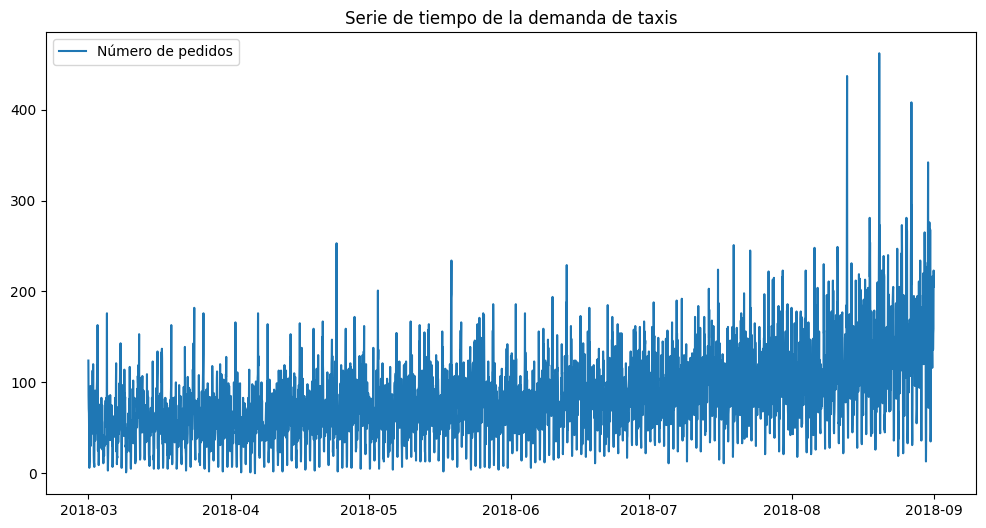

In [287]:
# Crear un gráfico con la serie de tiempo de la demanda de taxis
plt.figure(figsize=(12, 6))
plt.title('Serie de tiempo de la demanda de taxis')
plt.plot(df.index, df['num_orders'], label='Número de pedidos')
plt.legend()
plt.show()

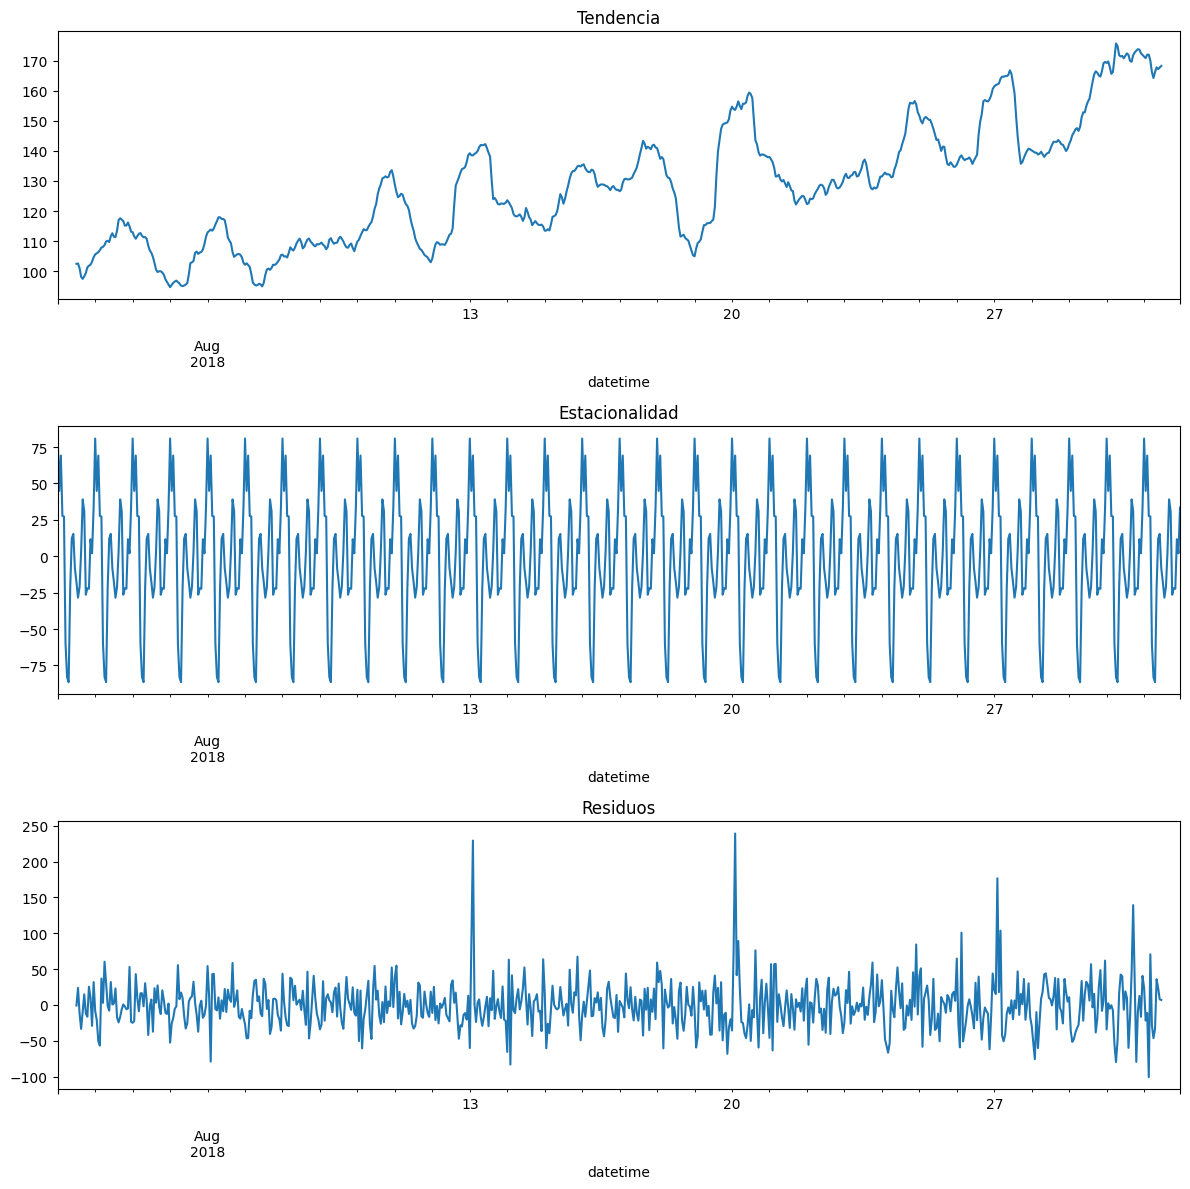

In [288]:
# Crear gráficos de tendencia, estacionalidad y residuos para la columna num_orders para el ultimo mes
decomposed = seasonal_decompose(df['num_orders'][-720:])

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuos')
plt.tight_layout()

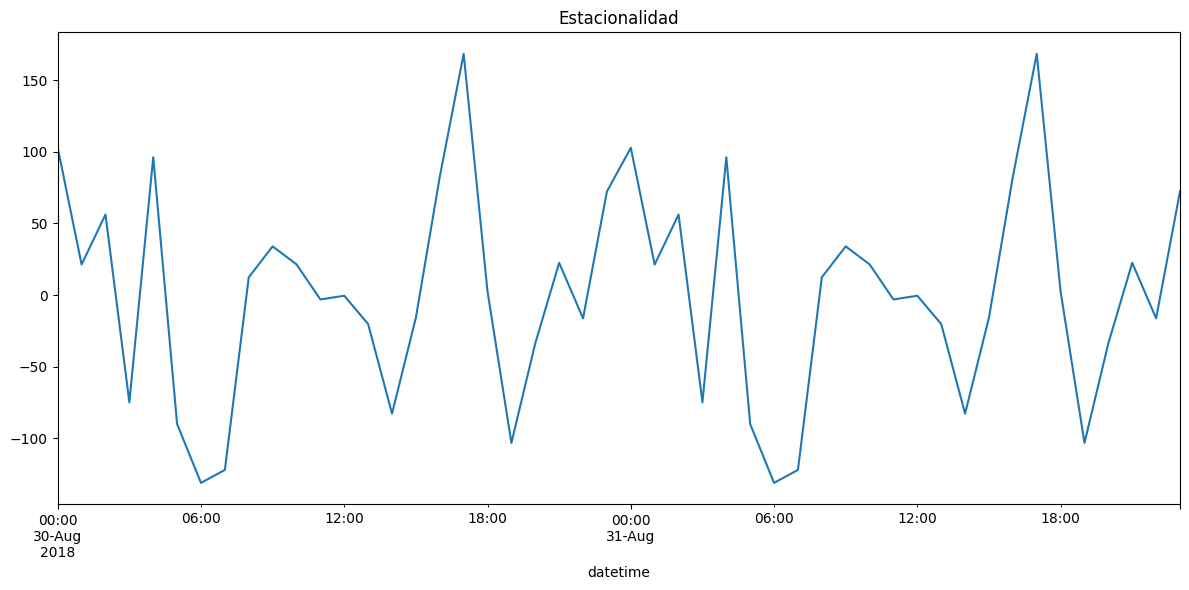

In [289]:
# Crear un gráfico de estacionalidad para la columna num_orders para los últimos 2 días
decomposed = seasonal_decompose(df['num_orders'][-48:])

plt.figure(figsize=(12, 6))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.tight_layout()

### Conclusión intermedia

Al realizar el análisis de tendencias y estacionalidad, además de graficar el conjunto de datos completo, se hizo un acotamiento de un mes y otro de dos días para poder observar de forma más clara dichos patrones. 

Gracias al análisis se puede notar que:
- Hay una tendencia de aumento en el número de ordenes con el paso de los meses (al menos dentro del rango de datos provistos).
- La estacionalidad refleja un ciclo que se repite cada día.
- Durante el día la hora pico de ordenes sucede al rededor de las `18:00` hrs.

Tomando en cuenta las observaciones previas sería muy útil considerar la creación de nuevas características (desfase y media móvil) ya que existe un claro patrón de estacionalidad.

**NOTA:** Para poder encontrar algún tipo de estacionalidad a mayor escala, por ejemplo entre los primeros y los últimos meses del año, sería necesario contar con datos que abarquen un rango de tiempo más amplio.

## Formación

In [290]:
# Crear características adicionales de la serie de tiempo

# Características de la fecha
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

# Características de desfase de 24 horas
df['lag_24'] = df['num_orders'].shift(24)

# Características de desfase de 48 horas
df['lag_48'] = df['num_orders'].shift(48)

# Características de desfase de 72 horas
df['lag_72'] = df['num_orders'].shift(72)

# Características de media móvil de 24 horas
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()

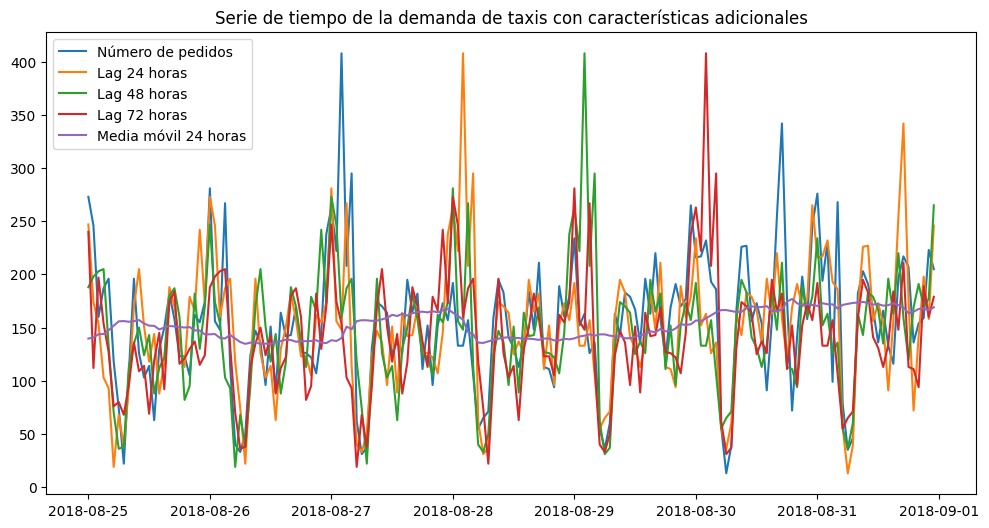

In [291]:
# Crear un gráfico de la serie de tiempo de la demanda de taxis con las características adicionales (útlimos 7 días)
plt.figure(figsize=(12, 6))
plt.title('Serie de tiempo de la demanda de taxis con características adicionales')
plt.plot(df.index[-168:], df['num_orders'][-168:], label='Número de pedidos')
plt.plot(df.index[-168:], df['lag_24'][-168:], label='Lag 24 horas')
plt.plot(df.index[-168:], df['lag_48'][-168:], label='Lag 48 horas')
plt.plot(df.index[-168:], df['lag_72'][-168:], label='Lag 72 horas')
plt.plot(df.index[-168:], df['rolling_mean'][-168:], label='Media móvil 24 horas')
plt.legend()
plt.show()

In [292]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

# Dividir los conjuntos de entrenamiento y prueba en características y objetivos
train_features = train.drop('num_orders', axis=1)
train_targets = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_targets = test['num_orders']

In [293]:
# Crear una función para encontrar los mejores hiperparámetros
def find_best_params(model, param_grid, train_features, train_targets):
    # Realizar una búsqueda en cuadrícula de los hiperparámetros
    grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0)
    grid.fit(train_features, train_targets)
    
    # Imprimir los mejores hiperparámetros y el mejor score
    print('Tipo de modelo:', type(model).__name__)
    print('Mejores parámetros:', grid.best_params_)
    print('Mejor score (RMSE):', np.sqrt(abs(grid.best_score_)))
    print()

In [294]:
# Definir los hiperparámetros a probar
param_grid_lr = {}
param_grid_rf = {'n_estimators': np.arange(10, 101, 10), 'max_depth': np.arange(1, 10)}
param_grid_CatBoost = {'iterations': np.arange(10, 101, 10), 'depth': np.arange(1, 10)}
param_grid_XGBoost = {'n_estimators': np.arange(10, 101, 10), 'max_depth': np.arange(1, 10)}

In [295]:
# Encontrar los mejores hiperparámetros
# model_lr = LinearRegression()
# find_best_params(model_lr, param_grid_lr, train_features, train_targets)

# model_rf = RandomForestRegressor(random_state=12345)
# find_best_params(model_rf, param_grid_rf, train_features, train_targets)

# model_CatBoost = CatBoostRegressor(random_state=12345, silent=True)
# find_best_params(model_CatBoost, param_grid_CatBoost, train_features, train_targets)

# model_XGBoost = xgb.XGBRegressor(random_state=12345)
# find_best_params(model_XGBoost, param_grid_XGBoost, train_features, train_targets)

    Tipo de modelo: LinearRegression
    Mejores parámetros: {}
    Mejor score (RMSE): 24.50756568094028

    Tipo de modelo: RandomForestRegressor
    Mejores parámetros: {'max_depth': 7, 'n_estimators': 70}
    Mejor score (RMSE): 24.91958853549354

    Tipo de modelo: CatBoostRegressor
    Mejores parámetros: {'depth': 2, 'iterations': 90}
    Mejor score (RMSE): 24.805401789277084

    Tipo de modelo: XGBRegressor
    Mejores parámetros: {'max_depth': 1, 'n_estimators': 100}
    Mejor score (RMSE): 24.870289727452583

## Prueba

In [296]:
# Crear función para evaluar el modelo en el conjunto de prueba y calcular el RMSE
def eval_model(model, train_features, train_target, test_features, test_target):
    # Entrenar el modelo
    model.fit(train_features, train_target)
    
    # Realizar predicciones
    train_pred = model.predict(train_features)
    test_pred = model.predict(test_features)
    
    # Calcular el RMSE
    train_rmse = np.sqrt(mean_squared_error(train_target, train_pred))
    test_rmse = np.sqrt(mean_squared_error(test_target, test_pred))
    
    # Imprimir los resultados
    print('Tipo de modelo:', type(model).__name__)
    print('RMSE en el conjunto de entrenamiento:', train_rmse)
    print('RMSE en el conjunto de prueba:', test_rmse)
    print()

### Regresión lineal

In [297]:
# Crear modelo de regresión lineal
model_lr = LinearRegression()

# Entrenar y evaluar el modelo de regresión lineal
eval_model(model_lr, train_features, train_targets, test_features, test_targets)

Tipo de modelo: LinearRegression
RMSE en el conjunto de entrenamiento: 24.459857473248253
RMSE en el conjunto de prueba: 42.97381769431366



### Bosque Aleatorio

In [298]:
# Crear modelo de regresión random forest
model_rf = RandomForestRegressor(random_state=12345, n_estimators=70, max_depth=7)

# Entrenar y evaluar el modelo de regresión random forest
eval_model(model_rf, train_features, train_targets, test_features, test_targets)

Tipo de modelo: RandomForestRegressor
RMSE en el conjunto de entrenamiento: 20.675050604075594
RMSE en el conjunto de prueba: 43.306851819297414



### CatBoost

In [299]:
# Crear modelo de regresión CatBoost
model_CatBoost = CatBoostRegressor(random_state=12345, iterations=90, depth=2, verbose=0)

# Entrenar y evaluar el modelo de regresión CatBoost
eval_model(model_CatBoost, train_features, train_targets, test_features, test_targets)

Tipo de modelo: CatBoostRegressor
RMSE en el conjunto de entrenamiento: 22.762642424007133
RMSE en el conjunto de prueba: 43.20915469354481



### XGBoost

In [300]:
# Crear modelo de regresión XGBoost
model_XGBoost = xgb.XGBRegressor(random_state=12345, n_estimators=100, max_depth=1, verbosity=0)

# Entrenar y evaluar el modelo de regresión XGBoost
eval_model(model_XGBoost, train_features, train_targets, test_features, test_targets)

Tipo de modelo: XGBRegressor
RMSE en el conjunto de entrenamiento: 23.654735933616987
RMSE en el conjunto de prueba: 43.90188464011501



### Conclusión intermedia

`Bosque Aleatorio` y `CatBoost` parecen ser los modelos con mejor desempeño tanto en el conjunto de entrenamiento como en el de prueba.

# Conclusión General

Durante este proyecto para el servicio de taxi `Sweet Lift Taxi`:

1. Hemos realizado un análisis exploratorio de los datos, enfocándonos en la variable `num_orders`. Remuestreamos los datos por una hora para mejorar la calidad de los mismos.

2. Implementamos y comparamos varios modelos de regresión (`Regresión lineal`, `Bosque aleatorio`, `CatBoost` y `XGBoost`) para predecir el número de pedidos de taxis en la próxima hora.

3. Mejoramos la precisión de los modelos mediante ajuste de hiperparámetros, además de añadir características de desfase y promedio móvil para capturar mejor las tendencias y estacionalidad en los datos.

4. A pesar de que todos los modelos lograron un `RMSE` por debajo del umbral requerido de **48**, se eligió el modelo de `CatBoost` ya que de las dos mejores opciones fué el que obtuvo el `RMSE` más bajo.

En resumen, hemos desarrollado un modelo que puede predecir con suficiente precisión el número de pedidos de taxis en la próxima hora, proporcionando una valiosa herramienta para Sweet Lift Taxi y resaltando la importancia del manejo cuidadoso de los datos, la ingeniería de características efectiva, y un enfoque equilibrado entre la precisión y la eficiencia del modelo.
